In [6]:
%matplotlib inline
import numpy as np
import pandas as pd
import backtrader as bt
import datetime
import matplotlib.pyplot as plt

In [7]:
data = pd.read_csv('data/IH.CFX.csv', index_col = 'trade_date', parse_dates=True)
data['volume'] = data['vol']
data

,Unnamed: 0,ts_code,pre_close,pre_settle,open,high,low,close,settle,vol,...,lower_bond,threshold,down_prob,middle_prob,up_prob,ma_1,ma_2,ma_3,ma_4,volume
trade_date,,,,,,,,,,,,,,,,,,,,,
2017-01-10,725,IH.CFX,2312.2,2313.0,2312.2,2317.4,2305.2,2307.4,2311.2,3503.0,...,-1.099929,1.258523,0.088555,0.534003,0.377442,1.063098,-4.458365,1.678214,4.213385,3503.0
2017-01-11,724,IH.CFX,2307.4,2311.2,2310.2,2315.2,2296.4,2298.6,2301.6,4037.0,...,-1.084535,1.264241,0.137316,0.265582,0.597103,1.032019,-3.067410,0.768630,3.885534,4037.0
2017-01-12,723,IH.CFX,2298.6,2301.6,2299.0,2305.8,2286.2,2290.8,2294.4,4039.0,...,-1.074567,1.265382,0.158102,0.282901,0.558996,1.000272,-3.255322,1.185628,3.808289,4039.0
2017-01-13,722,IH.CFX,2290.8,2294.4,2291.2,2315.0,2290.2,2305.0,2304.6,4155.0,...,-1.055678,1.262510,0.136097,0.273649,0.590255,1.715278,-2.806241,0.783976,3.793391,4155.0
2017-01-16,721,IH.CFX,2305.0,2304.6,2302.0,2332.8,2285.0,2325.2,2316.0,6730.0,...,-1.055678,1.262510,0.117229,0.455628,0.427143,2.252955,-2.203313,0.725141,4.350996,6730.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-17,984,IH.CFX,2950.6,2950.4,2951.2,2962.6,2935.0,2956.2,2953.6,29648.0,...,-0.970611,1.208042,0.404170,0.340134,0.255696,0.243853,5.086254,7.945654,9.503284,29648.0
2025-09-18,983,IH.CFX,2956.2,2953.6,2965.6,2976.0,2888.4,2910.8,2907.8,31314.0,...,-0.962091,1.205239,0.125875,0.330556,0.543569,0.378619,3.211670,5.995922,6.134633,31314.0
2025-09-19,982,IH.CFX,2910.8,2903.4,2917.4,2932.0,2904.4,2913.4,2917.4,29901.0,...,-0.962091,1.205239,0.164747,0.360466,0.474787,-0.936087,2.918543,5.155708,6.758657,29901.0


In [8]:
#创建一个策略
class TestStrategy(bt.Strategy):
    params = (
        ('maperiod', 20),
    )
 #记录功能
    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # 引用到close line
        self.dataclose = self.datas[0].close

        # 跟踪订单状态以及买卖价格和佣金
        self.order = None
        self.buyprice = None
        self.buycomm = None

        # 增加移动均线
        self.sma = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.maperiod)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # 订单状态为提交和接受，不做处理
            return

        # 检查订单是否成交
        # 注意，没有足够现金的话，订单会被拒绝。
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        # 记录当前处理的close值
        self.log('Close, %.2f' % self.dataclose[0])

        # 订单是否
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # 大于均线就买
            if self.dataclose[0] > self.sma[0]:

                # BUY, BUY, BUY!!! (with all possible default parameters)
                self.log('BUY CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy()

        else:

            if self.dataclose[0] < self.sma[0]:
                # 小于均线卖卖卖！
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()


In [9]:
cerebro = bt.Cerebro()
cerebro.broker.setcommission(commission=0.001)

start_date = datetime.datetime(2020,1,1)
end_date = datetime.datetime(2025,1,1)
data_1 = bt.feeds.PandasData(dataname = data, fromdate = start_date, todate=end_date)
cerebro.adddata(data_1)
cerebro.addstrategy(TestStrategy)

0

In [10]:
print(f'initial value: {cerebro.broker.getvalue()}')
cerebro.run()
print(f'final value  : {cerebro.broker.getvalue()}')

cerebro.plot()
# plt.show()

initial value: 10000.0
2020-02-06, Close, 2846.80
2020-02-07, Close, 2843.80
2020-02-10, Close, 2831.00
2020-02-11, Close, 2864.40
2020-02-12, Close, 2878.00
2020-02-13, Close, 2865.60
2020-02-14, Close, 2885.80
2020-02-17, Close, 2946.60
2020-02-17, BUY CREATE, 2946.60
2020-02-18, BUY EXECUTED, Price: 2930.20, Cost: 2930.20, Comm 2.93
2020-02-18, Close, 2915.80
2020-02-18, SELL CREATE, 2915.80
2020-02-19, SELL EXECUTED, Price: 2915.80, Cost: 2930.20, Comm 2.92
2020-02-19, OPERATION PROFIT, GROSS -14.40, NET -20.25
2020-02-19, Close, 2921.00
2020-02-19, BUY CREATE, 2921.00
2020-02-20, BUY EXECUTED, Price: 2927.40, Cost: 2927.40, Comm 2.93
2020-02-20, Close, 2973.60
2020-02-21, Close, 2969.60
2020-02-24, Close, 2923.20
2020-02-25, Close, 2911.60
2020-02-26, Close, 2909.80
2020-02-27, Close, 2909.80
2020-02-28, Close, 2821.00
2020-02-28, SELL CREATE, 2821.00
2020-03-02, SELL EXECUTED, Price: 2843.60, Cost: 2927.40, Comm 2.84
2020-03-02, OPERATION PROFIT, GROSS -83.80, NET -89.57
2020-03-

<IPython.core.display.Javascript object>

[[<Figure size 640x480 with 4 Axes>]]

<IPython.core.display.Javascript object>

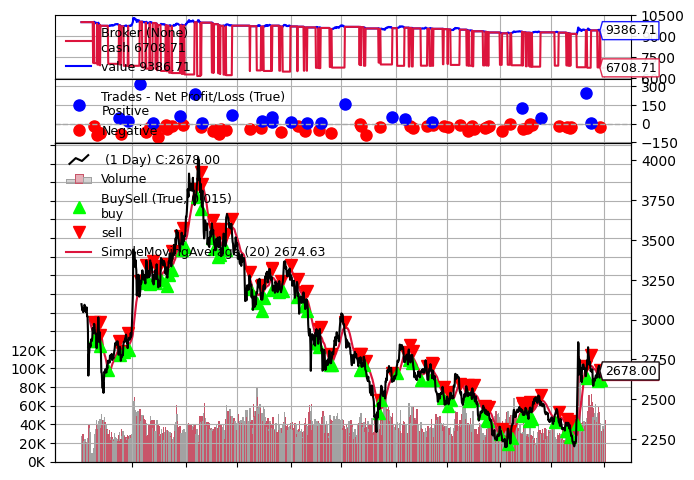

In [22]:
cerebro.plot(height=20, width = 20)[0][0]